# Introduction to Data Science - Assignment 7
---
## IMDB Reviews Dataset

In [1]:
import json
import gc
from tqdm import tqdm 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sea
from tabulate import tabulate

from wordcloud import WordCloud, STOPWORDS

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import emoji

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

from sklearn.semi_supervised import LabelPropagation, SelfTrainingClassifier

from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 0. Read Data

In [2]:
def read_jsonl(path: str, labels: list):
	data = pd.DataFrame(columns=labels)
	with open(path, 'r') as f:
		for line in f:
			observe = json.loads(line)
			observe['embedding'] = np.array(observe['embedding'])#.reshape(1, -1)
			data.loc[len(data)] = observe
		
	return data

In [3]:
data_train = read_jsonl('./train_imdb.jsonl', ['text', 'label', 'embedding'])
data_test = read_jsonl('./test_imdb.jsonl', ['text', 'label', 'embedding'])
data_unlabeled = read_jsonl('./aug_imdb_unlabeled.jsonl', ['text', 'embedding'])


# 1. EDA

## Preprocess and Tokenize

In [80]:
def preprocess_tokenize(x, html = True, url = True, username = True, hashtag = True, rep = True, lower = True,
			   stopword = True, punctuation = True, demojize = True, stemming = True):

	if(html):
		x = re.sub(re.compile('<.*?>') , '', x)
	if(url):
		x = re.sub(r'http\S+|www\S+', '', x)
	if(username):
		x = re.sub(r'@[^ ]+', '', x)
	if(hashtag):
		x = re.sub(r'#', '', x)
	if(rep):
		x = re.sub(r'(.)\1{2,}', r'\1', x)
	if(demojize):
		x = emoji.demojize(x, language='en')
	if(punctuation):
		puncs = [
			'[', '!', '"', '#', '%', '\\', '(', ')', '*',
			'+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', 
			'/', '^', '_', '`', '{', '|', '}', '~',
			'’', '”', '“', '′', '‘', ']','؟','؛','«','»','،','٪' #,'\''
		]
		pattern = r'[' + re.escape(''.join(puncs)) + r']'
		x = re.sub(pattern, ' ', x)
		
	
	tokens = nltk.word_tokenize(x)
	
	tokens = [token.replace("n't", "not") for token in tokens]
	tokens = [token.replace("'s", "is") for token in tokens]

	if(lower):
		tokens = [token.lower() for token in tokens]
	if(stopword):
		stop_words = set(stopwords.words('english'))
		tokens = [token for token in tokens if token not in stop_words]
	if(stemming):
		stemmer = PorterStemmer()
		tokens = [stemmer.stem(token) for token in tokens]

	x = ' '.join(tokens)

	return x

In [81]:
data_train['clean'] = data_train['text'].apply(lambda x: preprocess_tokenize(x, stemming=False, stopword=False))

## Distributions

### Number of Tokens

In [82]:
data_train['len'] = data_train['clean'].apply(lambda x: len(nltk.word_tokenize(x)))

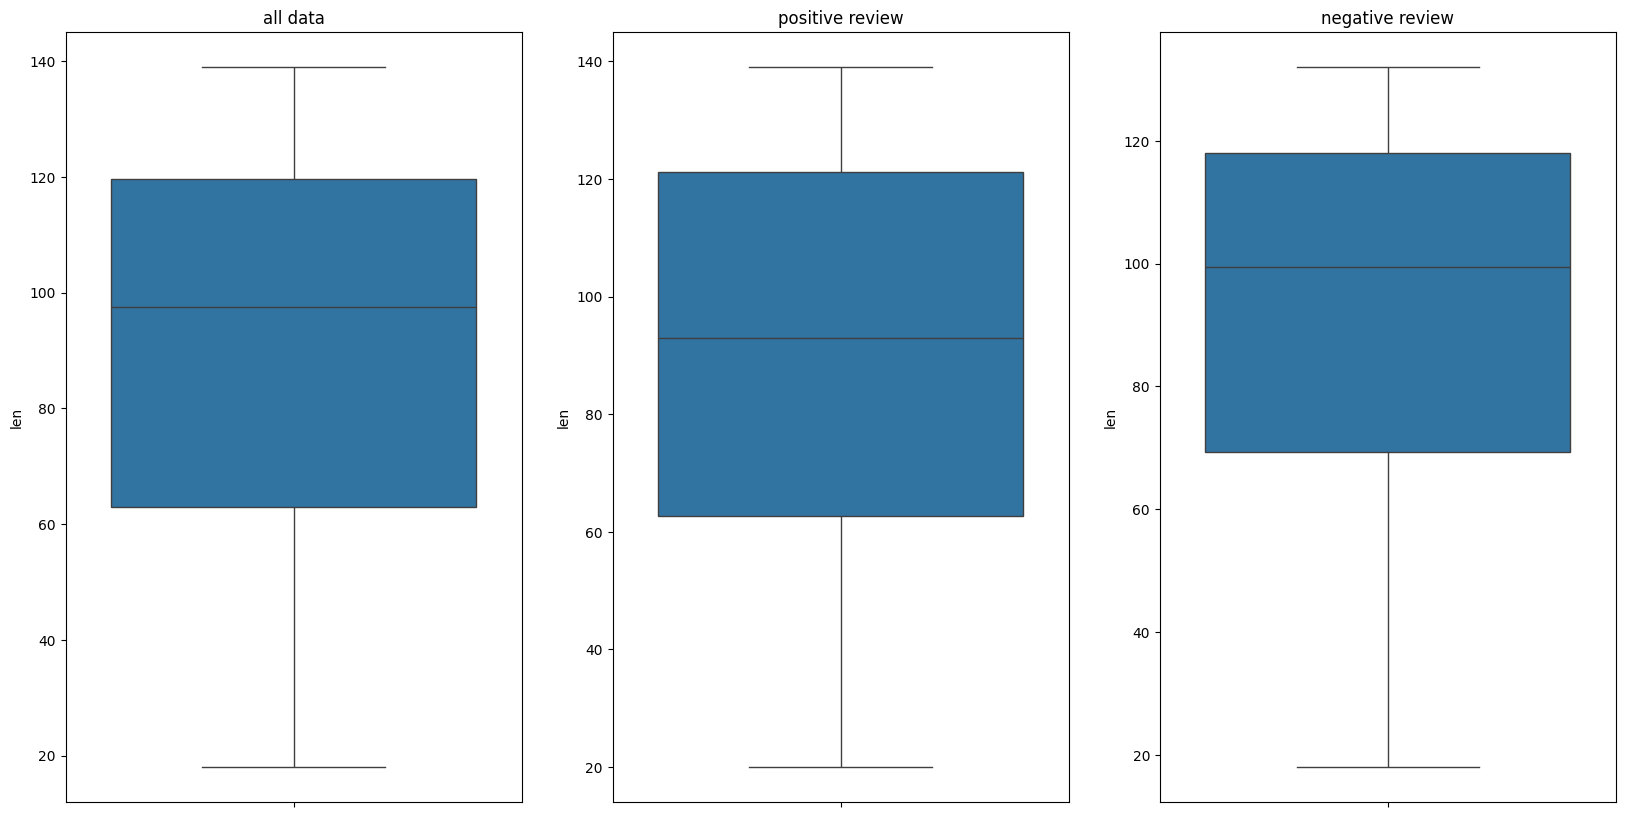

In [84]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20, 10))
sea.boxplot(ax=axes[0], y = data_train['len']).set_title('all data')
sea.boxplot(ax=axes[1], y = data_train[data_test['label'] == 1]['len']).set_title('positive review')
sea.boxplot(ax=axes[2], y = data_train[data_test['label'] == 0]['len']).set_title('negative review')

plt.show()

### Number of Letters

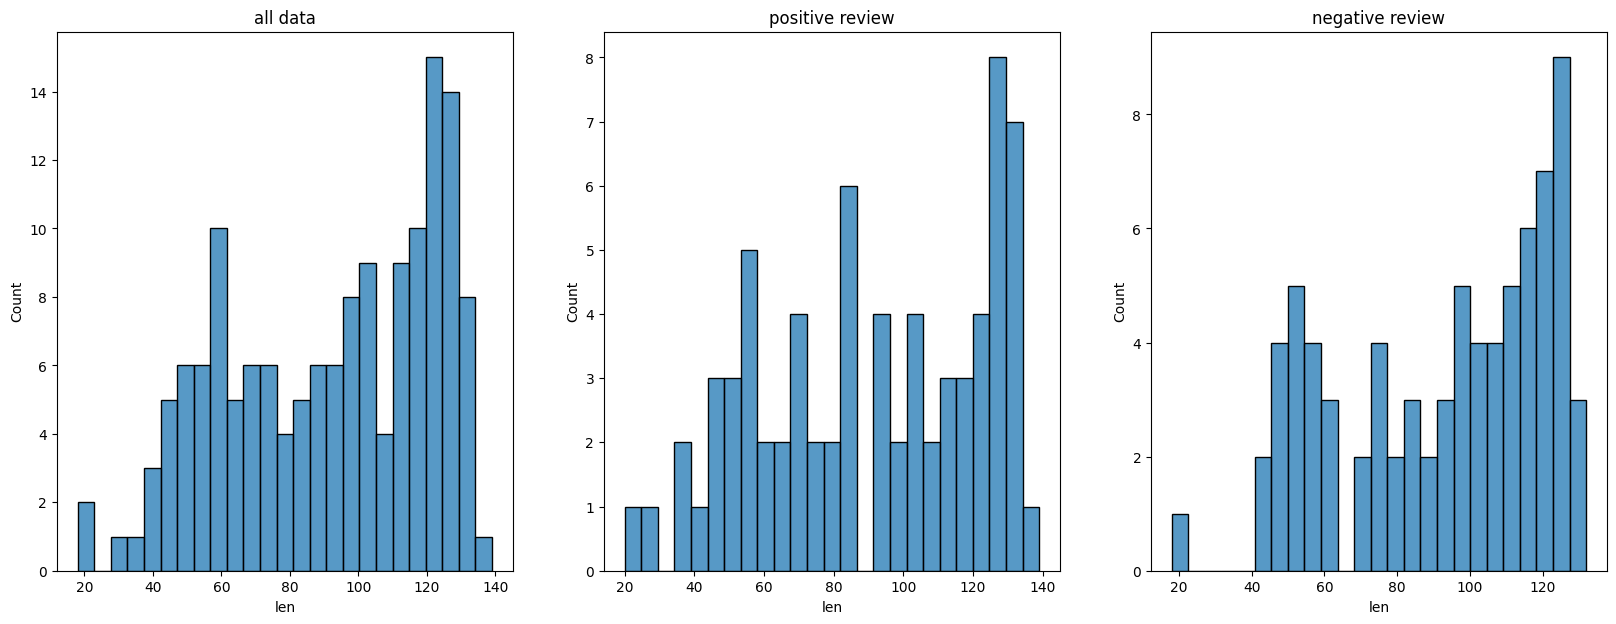

In [109]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize = (20, 7))
sea.histplot(ax=axes[0], x = data_train['len'], bins=25).set_title('all data')
sea.histplot(ax=axes[1], x = data_train[data_test['label'] == 1]['len'], bins=25).set_title('positive review')
sea.histplot(ax=axes[2], x = data_train[data_test['label'] == 0]['len'], bins=25).set_title('negative review')

plt.show()

## Word Cloud

### All reviews

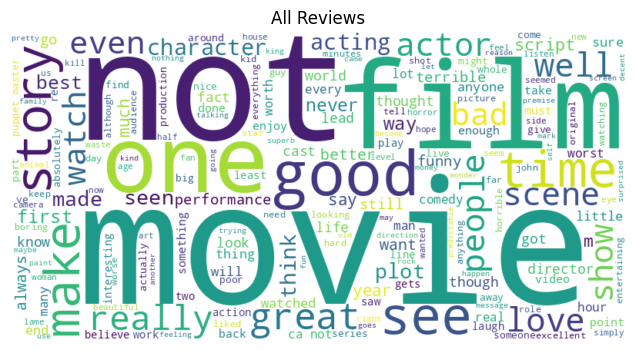

In [108]:
texts = data_train['clean']
texts = ' '.join(texts.astype(str))
wordcloud_combined = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400, colormap='viridis').generate(texts)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud_combined, interpolation='bilinear')
plt.axis('off')
plt.title('All Reviews')

plt.show()

### Positive and Negative Reviews

In [93]:
pos_texts = data_train[data_train['label'] == 1]['clean']
neg_texts = data_train[data_train['label'] == 0]['clean']

pos_texts = ' '.join(pos_texts.astype(str))
neg_texts = ' '.join(neg_texts.astype(str))

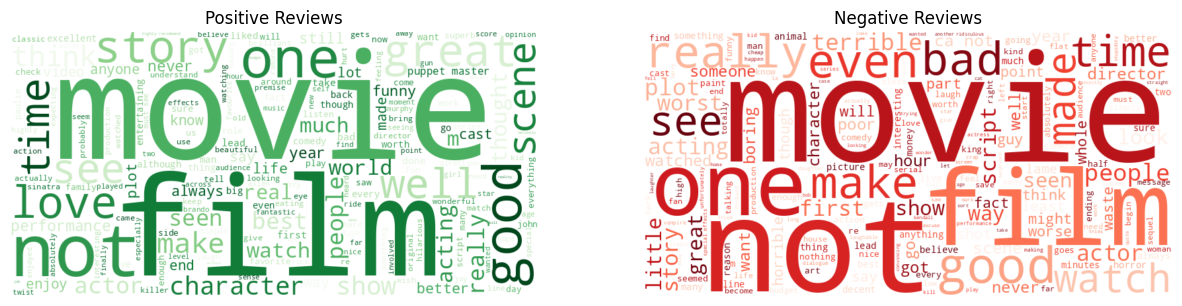

In [94]:
wordcloud_pos = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400, colormap='Greens').generate(pos_texts)
wordcloud_neg = WordCloud(stopwords=STOPWORDS, background_color='white', width=800, height=400, colormap='Reds').generate(neg_texts)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.show()

### Only in Positive or Negative Review

In [105]:
from collections import Counter

# return count(A) - count(B)
def count_differenc(A: str, B: str):
      
	A_counts = Counter(A.split())
	B_counts = Counter(B.split())
	diff_counts = A_counts.copy()
	for word, count in B_counts.items():
		diff_counts[word] -= count
		if diff_counts[word] <= 0:
			del diff_counts[word]

	only_A = diff_counts.copy()
	for word in diff_counts:
		if word in STOPWORDS:
			del only_A[word]

	return only_A

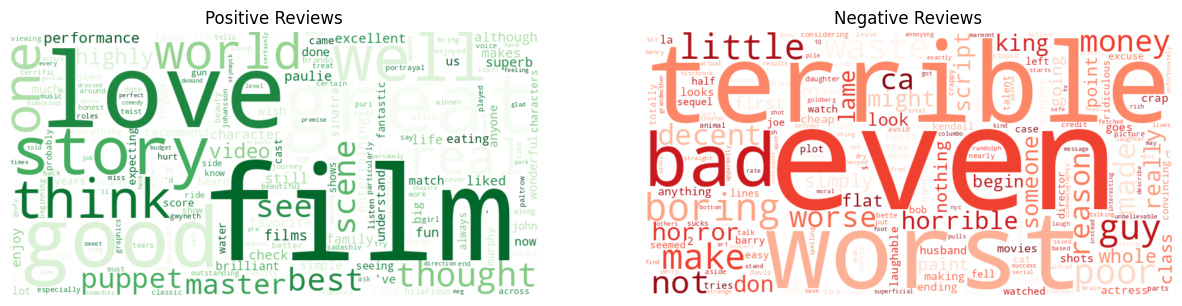

In [107]:
only_positive = count_differenc(pos_texts, neg_texts)
only_negative = count_differenc(neg_texts, pos_texts)

wordcloud_pos = WordCloud(stopwords=STOPWORDS, width=800, height=400, background_color='white', colormap='Greens').generate_from_frequencies(only_positive)
wordcloud_neg = WordCloud(stopwords=STOPWORDS, width=800, height=400, background_color='white', colormap='Reds').generate_from_frequencies(only_negative)

plt.figure(figsize=(15, 8))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Positive Reviews')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Negative Reviews')

plt.show()

## Most Common Words


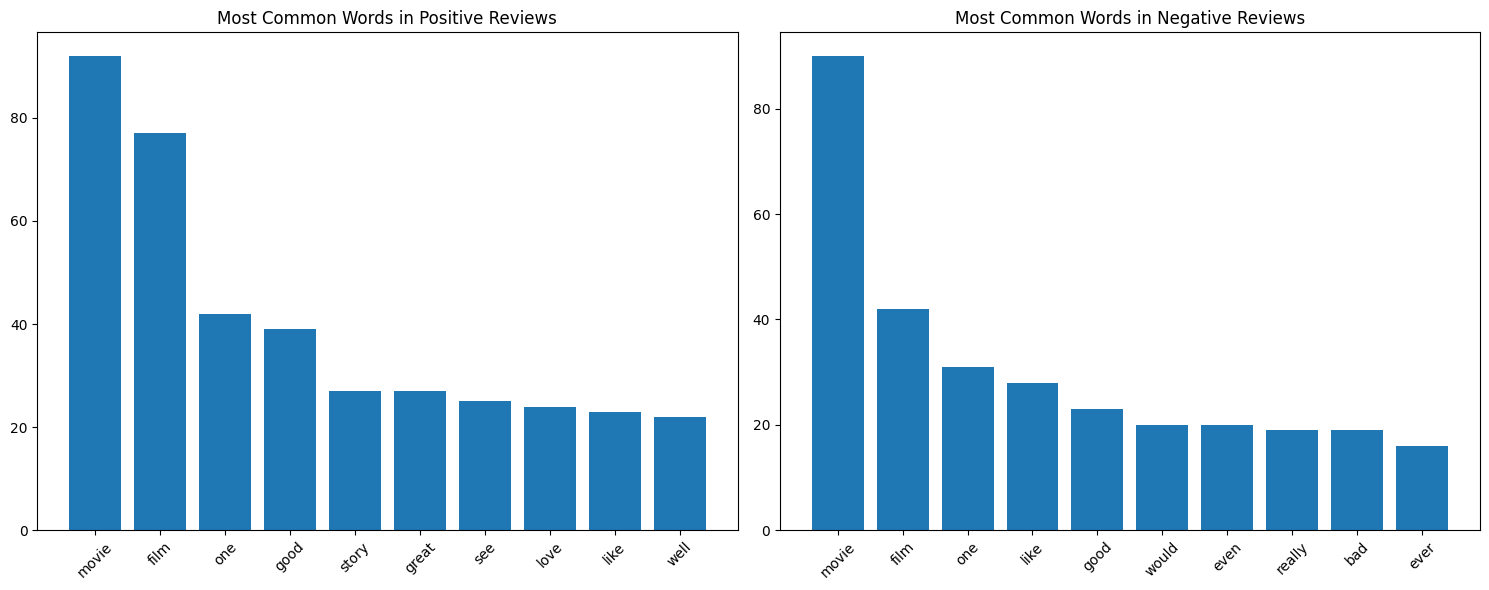

In [112]:
stop_words = set(stopwords.words('english'))
def get_common_words(texts, top_n=10):
    clean_words_list = texts.split()
    filtered_words = [word for word in clean_words_list if word not in stop_words]
    common_words = Counter(filtered_words).most_common(top_n)
    return zip(*common_words)

pos_words, pos_counts = get_common_words(pos_texts)
neg_words, neg_counts = get_common_words(neg_texts)

plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.bar(pos_words, pos_counts)
plt.xticks(rotation=45)
plt.title('Most Common Words in Positive Reviews')

plt.subplot(1, 2, 2)
plt.bar(neg_words, neg_counts)
plt.xticks(rotation=45)
plt.title('Most Common Words in Negative Reviews')

plt.tight_layout()
plt.show()

# 2. Feature Engineering

In [ ]:
pca = PCA(n_components=2)
xpca = pca.fit_transform(np.concatenate(data_train['embedding']).reshape(len(data_train), -1))

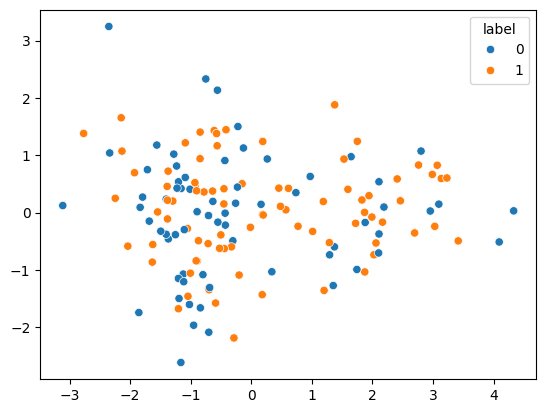

In [ ]:
sea.scatterplot(x = xpca[:, 0], y = xpca[:, 1], hue=data_train['label'])
plt.show()

# 3. Semi-Supervised

## Utils

In [4]:
def show_classification_result(name, y_pred, ytest):
	results = []
	classification_reports = {}
	accuracy = accuracy_score(ytest, y_pred)
	results.append([name, accuracy])
	classification_reports[name] = classification_report(ytest, y_pred, output_dict=True)

	print(tabulate(results, headers=["Classifier", "Accuracy"], tablefmt="grid"))

	for name, report in classification_reports.items():
		print(f"\nClassification Report for {name}:")
		report_table = []
		for label, metrics in report.items():
			if label not in ["accuracy", "macro avg", "weighted avg"]:
				report_table.append([label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])
		print(tabulate(report_table, headers=["Class", "Precision", "Recall", "F1-score", "Support"], tablefmt="grid"))

	average_metrics_table = []
	for name, report in classification_reports.items():
		macro_avg = report["macro avg"]
		weighted_avg = report["weighted avg"]
		average_metrics_table.append([
			name,
			macro_avg['precision'],
			macro_avg['recall'],
			macro_avg['f1-score'],
			weighted_avg['precision'],
			weighted_avg['recall'],
			weighted_avg['f1-score']
		])

	print("\nAverage Metrics:")
	print(tabulate(
		average_metrics_table, 
		headers = [
			"Classifier", 
			"Macro Precision", 
			"Macro Recall", 
			"Macro F1-score", 
			"Weighted Precision", 
			"Weighted Recall", 
			"Weighted F1-score"
		], 
		tablefmt="grid"
	))

In [60]:
def MLClassifier(classifiers, xtrain, xtest, ytrain, ytest, just_acc = False):
	results = []
	classification_reports = {}

	for name, clf in classifiers.items():
		clf.fit(xtrain, ytrain)
		y_pred = clf.predict(xtest)
		accuracy = accuracy_score(ytest, y_pred)
		results.append([name, accuracy])
		classification_reports[name] = classification_report(ytest, y_pred, output_dict=True)

	print(tabulate(results, headers=["Classifier", "Accuracy"], tablefmt="grid"))
	if(just_acc):
		return
	for name, report in classification_reports.items():
		print(f"\nClassification Report for {name}:")
		report_table = []
		for label, metrics in report.items():
			if label not in ["accuracy", "macro avg", "weighted avg"]:
				report_table.append([label, metrics['precision'], metrics['recall'], metrics['f1-score'], metrics['support']])
		print(tabulate(report_table, headers=["Class", "Precision", "Recall", "F1-score", "Support"], tablefmt="grid"))

	average_metrics_table = []
	for name, report in classification_reports.items():
		macro_avg = report["macro avg"]
		weighted_avg = report["weighted avg"]
		average_metrics_table.append([
			name,
			macro_avg['precision'],
			macro_avg['recall'],
			macro_avg['f1-score'],
			weighted_avg['precision'],
			weighted_avg['recall'],
			weighted_avg['f1-score']
		])

	print("\nAverage Metrics:")
	print(tabulate(
		average_metrics_table, 
		headers = [
			"Classifier", 
			"Macro Precision", 
			"Macro Recall", 
			"Macro F1-score", 
			"Weighted Precision", 
			"Weighted Recall", 
			"Weighted F1-score"
		], 
		tablefmt="grid"
	))

In [6]:
classifiers = {
	"Decision Tree": DecisionTreeClassifier(),
	"Logistic Regression": LogisticRegression(max_iter=1000),
	"Gaussian Naive Bayes": GaussianNB(),
	"Gradiant Boosting": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    "SVM Linear": SVC(kernel='linear', probability=True), 
    "SVM Poly": SVC(kernel='poly', probability=True), 
    "SVM rbf": SVC(kernel='rbf', probability=True), 
    "SVM sigmoid": SVC(kernel='sigmoid', probability=True), 
}

## Train with labeled data using Texts (Bag of Words)

In [78]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(data_train['text']).toarray() 
X_test = vectorizer.transform(data_test['text']).toarray() 

In [79]:
len_train = data_train['embedding'].shape[0]
len_test = data_test['embedding'].shape[0]
MLClassifier(
    classifiers = classifiers,
    xtrain = X_train,
    xtest = X_test,
    ytrain = data_train['label'],
    ytest = data_test['label']
)

+----------------------+------------+
| Classifier           |   Accuracy |
+======================+============+
| Decision Tree        |   0.666667 |
+----------------------+------------+
| Logistic Regression  |   0.706667 |
+----------------------+------------+
| Gaussian Naive Bayes |   0.673333 |
+----------------------+------------+
| Gradiant Boosting    |   0.673333 |
+----------------------+------------+
| Random Forest        |   0.686667 |
+----------------------+------------+
| SVM Linear           |   0.726667 |
+----------------------+------------+
| SVM Poly             |   0.506667 |
+----------------------+------------+
| SVM rbf              |   0.533333 |
+----------------------+------------+
| SVM sigmoid          |   0.52     |
+----------------------+------------+

Classification Report for Decision Tree:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+

## Train with labeled data using Embeddings

In [80]:
len_train = data_train['embedding'].shape[0]
len_test = data_test['embedding'].shape[0]
MLClassifier(
    classifiers = classifiers,
    xtrain = np.concatenate(data_train['embedding']).reshape(len_train, -1),
    xtest = np.concatenate(data_test['embedding']).reshape(len_test, -1),
    ytrain = data_train['label'],
    ytest = data_test['label']
)

+----------------------+------------+
| Classifier           |   Accuracy |
+======================+============+
| Decision Tree        |   0.706667 |
+----------------------+------------+
| Logistic Regression  |   0.8      |
+----------------------+------------+
| Gaussian Naive Bayes |   0.78     |
+----------------------+------------+
| Gradiant Boosting    |   0.766667 |
+----------------------+------------+
| Random Forest        |   0.74     |
+----------------------+------------+
| SVM Linear           |   0.78     |
+----------------------+------------+
| SVM Poly             |   0.786667 |
+----------------------+------------+
| SVM rbf              |   0.793333 |
+----------------------+------------+
| SVM sigmoid          |   0.513333 |
+----------------------+------------+

Classification Report for Decision Tree:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+

## Labeling Using Traditional Methods


### 1. Kmeans 

In [28]:
pos = data_train[data_train['label'] == 1].reset_index(drop=True)
neg = data_train[data_train['label'] == 0].reset_index(drop=True)
pos_center = np.concatenate(pos['embedding']).reshape(len(pos), -1).mean(axis = 0).reshape(1, -1)
neg_center = np.concatenate(neg['embedding']).reshape(len(neg), -1).mean(axis = 0).reshape(1, -1)

In [29]:
initial_centroids = np.concatenate([neg_center, pos_center], axis=0)
kmeans = KMeans(n_clusters=2, init=initial_centroids)
kmeans.fit(np.concatenate(data_unlabeled['embedding']).reshape(len(data_unlabeled), -1))

KMeans(init=array([[ 0.06219141,  0.02254852,  0.26842909, ..., -0.06077539,
         0.26450102,  0.04059535],
       [-0.00781909, -0.05335282,  0.27962444, ..., -0.05041033,
         0.22611628, -0.00036713]]),
       n_clusters=2)

In [30]:
data_unlabeled['label'] = kmeans.labels_

In [31]:
augmented_data = pd.concat([data_unlabeled, data_train]).reset_index(drop=True)

len_aug = augmented_data['embedding'].shape[0]
len_test = data_test['embedding'].shape[0]
MLClassifier(
    classifiers = classifiers,
    xtrain = np.concatenate(augmented_data['embedding']).reshape(len_aug, -1),
    xtest = np.concatenate(data_test['embedding']).reshape(len_test, -1),
    ytrain = augmented_data['label'],
    ytest = data_test['label']
)

+----------------------+------------+
| Classifier           |   Accuracy |
+======================+============+
| Decision Tree        |   0.513333 |
+----------------------+------------+
| Logistic Regression  |   0.593333 |
+----------------------+------------+
| Gaussian Naive Bayes |   0.586667 |
+----------------------+------------+
| Gradiant Boosting    |   0.58     |
+----------------------+------------+
| Random Forest        |   0.573333 |
+----------------------+------------+
| SVM Linear           |   0.573333 |
+----------------------+------------+
| SVM Poly             |   0.58     |
+----------------------+------------+
| SVM rbf              |   0.586667 |
+----------------------+------------+
| SVM sigmoid          |   0.586667 |
+----------------------+------------+

Classification Report for Decision Tree:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+

### 2. KNN from Scratch

In [14]:
def euclidean_distance(x1: np.array, x2: np.array):
	assert x1.shape == x2.shape
	n = x1.shape[0]
	return (1 / n) * np.sum((x1 - x2) ** 2) 

def knn(unlabeled_embedding: pd.Series, labeled_data: pd.DataFrame, k = 5, threshold = 1e-3):
	labeled_data['dist'] = labeled_data['embedding'].apply(lambda x: euclidean_distance(x, unlabeled_embedding))
	sorted_data = labeled_data.sort_values(by='dist').reset_index()
	filtered_data = sorted_data.iloc[:k]
    
	if(filtered_data['dist'][0] > threshold):
		return -1
	return filtered_data['label'].mode()[0]
    

In [66]:
data_unlabeled['label'] = data_unlabeled['embedding'].apply(lambda x: knn(x, data_train, 7, threshold=0.025))
data_unlabeled['label'].value_counts()

label
 0    545
 1    460
-1      9
Name: count, dtype: int64

In [52]:
f"{(data_unlabeled['label'] == -1).sum() / len(data_unlabeled) * 100:.2f} %"

'53.65 %'

In [70]:
for x in range(10, 26):
	threshold = x / 1000
	data_unlabeled['label'] = data_unlabeled['embedding'].apply(lambda x: knn(x, data_train, 7, threshold=threshold))
	
	print(f"using threshold {threshold}, labeled {(data_unlabeled['label'] != -1).sum() / len(data_unlabeled) * 100:.2f} % of data")
	data_labeled = data_unlabeled[data_unlabeled['label'] != -1]
	augmented_data = pd.concat([data_labeled, data_train]).sample(frac=1).reset_index(drop=True)

	len_aug = augmented_data['embedding'].shape[0]
	len_test = data_test['embedding'].shape[0]
	MLClassifier(
		classifiers = {'Logistic Regression': LogisticRegression(max_iter=1000)},
		xtrain = np.concatenate(augmented_data['embedding']).reshape(len_aug, -1),
		xtest = np.concatenate(data_test['embedding']).reshape(len_test, -1),
		ytrain = augmented_data['label'],
		ytest = data_test['label'],
		just_acc = True
	)

using threshold 0.01, labeled 0.49 % of data
+---------------------+------------+
| Classifier          |   Accuracy |
+=====================+============+
| Logistic Regression |        0.8 |
+---------------------+------------+
using threshold 0.011, labeled 2.07 % of data
+---------------------+------------+
| Classifier          |   Accuracy |
+=====================+============+
| Logistic Regression |   0.786667 |
+---------------------+------------+
using threshold 0.012, labeled 6.61 % of data
+---------------------+------------+
| Classifier          |   Accuracy |
+=====================+============+
| Logistic Regression |   0.786667 |
+---------------------+------------+
using threshold 0.013, labeled 15.38 % of data
+---------------------+------------+
| Classifier          |   Accuracy |
+=====================+============+
| Logistic Regression |   0.746667 |
+---------------------+------------+
using threshold 0.014, labeled 29.29 % of data
+---------------------+------

### 3. Label Propagation 

In [8]:
X = np.concatenate(data_train['embedding']).reshape(len(data_train), -1)

In [9]:
label_prop_model = LabelPropagation()
label_prop_model.fit(X, data_train['label'])


LabelPropagation()

In [10]:
to_predict = np.concatenate(data_unlabeled['embedding']).reshape(len(data_unlabeled), -1)
data_unlabeled['label'] = label_prop_model.predict(to_predict)

In [38]:
augmented_data = pd.concat([data_unlabeled, data_train]).reset_index(drop=True)

len_aug = augmented_data['embedding'].shape[0]
len_test = data_test['embedding'].shape[0]
MLClassifier(
    classifiers = classifiers,
    xtrain = np.concatenate(augmented_data['embedding']).reshape(len_aug, -1),
    xtest = np.concatenate(data_test['embedding']).reshape(len_test, -1),
    ytrain = augmented_data['label'],
    ytest = data_test['label']
)

+----------------------+------------+
| Classifier           |   Accuracy |
+======================+============+
| Decision Tree        |   0.64     |
+----------------------+------------+
| Logistic Regression  |   0.733333 |
+----------------------+------------+
| Gaussian Naive Bayes |   0.713333 |
+----------------------+------------+
| Gradiant Boosting    |   0.76     |
+----------------------+------------+
| Random Forest        |   0.72     |
+----------------------+------------+
| SVM Linear           |   0.7      |
+----------------------+------------+
| SVM Poly             |   0.746667 |
+----------------------+------------+
| SVM rbf              |   0.76     |
+----------------------+------------+
| SVM sigmoid          |   0.773333 |
+----------------------+------------+

Classification Report for Decision Tree:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+

### 4. Self Training

In [39]:
sf_classifiers = dict()
for classifier in classifiers:
    sf_classifiers[classifier] = SelfTrainingClassifier(classifiers[classifier])
    

In [40]:
data_unlabeled['label'] = -1

In [41]:
augmented_data = pd.concat([data_unlabeled, data_train]).reset_index(drop=True)

len_aug = augmented_data['embedding'].shape[0]
len_test = data_test['embedding'].shape[0]
MLClassifier(
    classifiers = sf_classifiers,
    xtrain = np.concatenate(augmented_data['embedding']).reshape(len_aug, -1),
    xtest = np.concatenate(data_test['embedding']).reshape(len_test, -1),
    ytrain = augmented_data['label'],
    ytest = data_test['label']
)

+----------------------+------------+
| Classifier           |   Accuracy |
+======================+============+
| Decision Tree        |   0.726667 |
+----------------------+------------+
| Logistic Regression  |   0.813333 |
+----------------------+------------+
| Gaussian Naive Bayes |   0.7      |
+----------------------+------------+
| Gradiant Boosting    |   0.726667 |
+----------------------+------------+
| Random Forest        |   0.48     |
+----------------------+------------+
| SVM Linear           |   0.786667 |
+----------------------+------------+
| SVM Poly             |   0.773333 |
+----------------------+------------+
| SVM rbf              |   0.793333 |
+----------------------+------------+
| SVM sigmoid          |   0.773333 |
+----------------------+------------+

Classification Report for Decision Tree:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+

## Labeling Using LLM

### PreProcess for LLM

In [49]:
def preprocess_text(x: str, html = True, url = True, username = False, hashtag = False, rep = False,
						 lower = False, punctuation = False, demojize = False):
	if(lower):
		x = x.lower()
	if(html):
		x = re.sub(re.compile('<.*?>') , '', x)
	if(url):
		x = re.sub(r'http\S+|www\S+', '', x)
	if(username):
		x = re.sub(r'@[^ ]+', '', x)
	if(hashtag):
		x = re.sub(r'#', '', x)
	if(rep):
		x = re.sub(r'(.)\1{2,}', r'\1', x)
	if(demojize):
		x = emoji.demojize(x, language='en')
	if(punctuation):
		puncs = [
			'[', '!', '"', '#', '%', '\\', '(', ')', '*',
			'+', ',', '-', '.', '/', ':', ';', '<', '=', '>', '?', 
			'/', '^', '_', '`', '{', '|', '}', '~',
			'’', '”', '“', '′', '‘', ']','؟','؛','«','»','،','٪' #,'\''
		]
		pattern = r'[' + re.escape(''.join(puncs)) + r']'
		x = re.sub(pattern, ' ', x)

	return x

In [51]:
cleaned_train = data_train['text'].apply(lambda x: preprocess_text(x))
cleaned_test = data_test['text'].apply(lambda x: preprocess_text(x))
cleaned_unl = data_unlabeled['text'].apply(lambda x: preprocess_text(x))

### Load Transformer Model

In [58]:
MODEL_ARGS = {
    'Name': './model',
    'DType': torch.bfloat16
}

def load_model(model_args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype = model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

In [59]:
model, tokenizer = load_model(MODEL_ARGS)

`flash-attention` package not found, consider installing for better performance: No module named 'flash_attn'.
Current `flash-attenton` does not support `window_size`. Either upgrade or use `attn_implementation='eager'`.
Loading checkpoint shards: 100%|██████████| 2/2 [00:16<00:00,  8.01s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [60]:
def generate_text(model, tokenizer, prompt, max_new_tokens = 100, do_sample=False, temperature=0.5):
	device = "cuda" if torch.cuda.is_available() else "cpu"	
	input_ids = tokenizer.encode(prompt, return_tensors='pt').to(device)
	if do_sample:
		output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=True, temperature=temperature)
	else:
		output_ids = model.generate(input_ids, max_new_tokens=max_new_tokens, do_sample=False, num_beams=1)

	output_text = tokenizer.decode(output_ids[0], skip_special_tokens=True)

	return output_text[len(prompt):]

### Chain of Thoughts

In [61]:
def propmpt_just_label(review):
	return f"""Question: label the following review, 1 for positive review, 0 for negative review.
review: this was a personal favorite of mine when i was young, it had everything that was great with 90's kids movies... lovable dinosaurs, cute kids, an eccentric villain, and a few great songs (and not the typical little mermaid\/beauty and the beast type songs, but ones that are atually entertaining)! i ran into this movie again recently and i still love it as much as ever! i recommend that everyone of every age should see this movie, and i definitely think that it should be introduced to the younger generations! sorry not the most informative, i'm in kinda a rush... just please, trust me. all who go against this movie are killing their inner child!
Answer:1

Question: label the following review, 1 for positive review, 0 for negative review.
review: maya is a woman without any interests. she just dreams her life away and wonders, why she does not feel fulfilled. this could be an interesting topic. that would need a good story, a nice setting and good dialogues. it doesn't have any of these. this movie is totally boring. there are only lengths and no climaxes.the only climax is shahrukh khan. but although i am a huge fan of his, i couldn't stand this movie. even he can't make this movie exiting. the movie is not as bad as \"king uncle\" and if you're an art-house fan or like it slow, you might maybe like it. it's not funny, it's not interesting, it's not catching. my recommendation: don't watch it.
Answer:0

Question: label the following review, 1 for positive review, 0 for negative review.
review: i thought the movie was extremely funny and actually very interesting. it was raw and honest and felt as if i was really watching the \"real people\" not actors. it's great entertainment, it also painted the people as human on our level not below us. it is a very good film.
Answer:1

Question: label the following review, 1 for positive review, 0 for negative review.
review: i watched this movie when joe bob briggs hosted monstervision on tnt. even he couldn't make this movie enjoyable. the only reason i watched it until the end is because i teach video production and i wanted to make sure my students never made anything this bad ... but it took all my intestinal fortitude to sit through it though. it's like watching your great grandmother flirting with a 15 year old boy ... excruciatingly painful. if you took the actual film, dipped it in paint thinner, then watched it, it would be more entertaining. seriously. if you see this movie in the bargin bin at s-mart, back away from it as if it were a rattlesnake.
Answer:0

Question: label the following review, 1 for positive review, 0 for negative review.
review: {review}
Answer:"""

def propmpt_label_and_explain(review):
	return f"""Question: label the following review, 1 for positive review, 0 for negative review.
review: this was a personal favorite of mine when i was young, it had everything that was great with 90's kids movies... lovable dinosaurs, cute kids, an eccentric villain, and a few great songs (and not the typical little mermaid\/beauty and the beast type songs, but ones that are atually entertaining)! i ran into this movie again recently and i still love it as much as ever! i recommend that everyone of every age should see this movie, and i definitely think that it should be introduced to the younger generations! sorry not the most informative, i'm in kinda a rush... just please, trust me. all who go against this movie are killing their inner child!
Answer:1, This review should be labeled as positive for several reasons. Firstly, the reviewer expresses that the movie was a "personal favorite" during their childhood, indicating a strong positive attachment. They praise the movie for having all the great elements of 90's kids movies, such as "lovable dinosaurs," "cute kids," "an eccentric villain," and "a few great songs," which they find "actually entertaining." Additionally, the reviewer mentions that they recently watched the movie again and still love it as much as ever, showing enduring appeal. They strongly recommend the movie to "everyone of every age" and believe it should be introduced to younger generations. Lastly, the review concludes with an emotional appeal, stating that those who dislike the movie are "killing their inner child," further emphasizing the positive sentiment.

Question: label the following review, 1 for positive review, 0 for negative review.
review: maya is a woman without any interests. she just dreams her life away and wonders, why she does not feel fulfilled. this could be an interesting topic. that would need a good story, a nice setting and good dialogues. it doesn't have any of these. this movie is totally boring. there are only lengths and no climaxes.the only climax is shahrukh khan. but although i am a huge fan of his, i couldn't stand this movie. even he can't make this movie exiting. the movie is not as bad as \"king uncle\" and if you're an art-house fan or like it slow, you might maybe like it. it's not funny, it's not interesting, it's not catching. my recommendation: don't watch it.
Answer:0, This review should be labeled as negative for several reasons. Firstly, the reviewer describes the main character, Maya, as a woman "without any interests" who "just dreams her life away," indicating a lack of engagement with the character. They acknowledge that the movie could have been interesting but criticize it for lacking a good story, a nice setting, and good dialogues. The reviewer states that the movie is "totally boring," with no climaxes and only lengths. Although they mention that Shahrukh Khan is a highlight, they note that even as a huge fan of his, they couldn't enjoy the movie. The reviewer further compares it unfavorably to another film, "King Uncle," and suggests that only art-house fans or those who like slow movies might find it appealing. They conclude by saying the movie is "not funny," "not interesting," and "not catching," and ultimately recommend not watching it.

Question: label the following review, 1 for positive review, 0 for negative review.
review: i thought the movie was extremely funny and actually very interesting. it was raw and honest and felt as if i was really watching the \"real people\" not actors. it's great entertainment, it also painted the people as human on our level not below us. it is a very good film.
Answer:1, This review should be labeled as positive for several reasons. Firstly, the reviewer describes the movie as "extremely funny" and "very interesting," indicating a high level of enjoyment. They appreciate the movie's raw and honest portrayal, feeling as if they were watching "real people" rather than actors, which suggests authenticity and relatability. The reviewer also highlights that the movie provided "great entertainment" and depicted the characters as human and relatable, rather than portraying them as inferior. Finally, they conclude by calling it a "very good film," further solidifying their positive opinion.

Question: label the following review, 1 for positive review, 0 for negative review.
review: i watched this movie when joe bob briggs hosted monstervision on tnt. even he couldn't make this movie enjoyable. the only reason i watched it until the end is because i teach video production and i wanted to make sure my students never made anything this bad ... but it took all my intestinal fortitude to sit through it though. it's like watching your great grandmother flirting with a 15 year old boy ... excruciatingly painful. if you took the actual film, dipped it in paint thinner, then watched it, it would be more entertaining. seriously. if you see this movie in the bargin bin at s-mart, back away from it as if it were a rattlesnake.
Answer:0, This review should be labeled as negative for several reasons. Firstly, the reviewer explicitly states that even Joe Bob Briggs, known for his engaging hosting of Monstervision, couldn't make the movie enjoyable. They mention that the only reason they watched it to the end was to ensure their video production students never made something so bad, indicating a very low opinion of the film's quality. The reviewer describes the experience as "excruciatingly painful," likening it to the discomfort of watching an inappropriate interaction between a great grandmother and a teenage boy. Additionally, they hyperbolically suggest that dipping the film in paint thinner and then watching it would be more entertaining. The final warning to avoid the movie as if it were a rattlesnake underscores their strong negative sentiment.

Question: label the following review, 1 for positive review, 0 for negative review.
review: {review}
Answer:"""


In [62]:
labels = []

In [20]:
for review in cleaned_unl:
	prompt = propmpt_just_label(review)

	ans = generate_text(
		model=model,
		tokenizer=tokenizer,
		prompt=prompt,
		max_new_tokens=1,
	)
	torch.cuda.empty_cache()
	gc.collect()
	labels.append(ans)

### Just Label Prompt

In [46]:
with open("labels_simple.txt", 'r') as f:
    labels = [line.rstrip('\n') for line in f]
labels = np.array([int(x) if x != '' else -1 for x in labels])
data_unlabeled['label'] = labels
data_unlabeled['label'].value_counts()
correctly_labeled = data_unlabeled[data_unlabeled['label'] != -1]

In [47]:
augmented_data = pd.concat([correctly_labeled, data_train]).reset_index(drop=True)

len_aug = augmented_data['embedding'].shape[0]
len_test = data_test['embedding'].shape[0]
MLClassifier(
    classifiers = classifiers,
    xtrain = np.concatenate(augmented_data['embedding']).reshape(len_aug, -1),
    xtest = np.concatenate(data_test['embedding']).reshape(len_test, -1),
    ytrain = augmented_data['label'],
    ytest = data_test['label']
)

+----------------------+------------+
| Classifier           |   Accuracy |
+======================+============+
| Decision Tree        |   0.6      |
+----------------------+------------+
| Logistic Regression  |   0.826667 |
+----------------------+------------+
| Gaussian Naive Bayes |   0.806667 |
+----------------------+------------+
| Gradiant Boosting    |   0.813333 |
+----------------------+------------+
| Random Forest        |   0.8      |
+----------------------+------------+
| SVM Linear           |   0.793333 |
+----------------------+------------+
| SVM Poly             |   0.833333 |
+----------------------+------------+
| SVM rbf              |   0.853333 |
+----------------------+------------+
| SVM sigmoid          |   0.853333 |
+----------------------+------------+

Classification Report for Decision Tree:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+

### Label + Explain Prompt

In [43]:
with open("labels_explained.txt", 'r') as f:
    labels = [line.rstrip('\n') for line in f]
labels = np.array([int(x) if x != '' else -1 for x in labels])
data_unlabeled['label'] = labels
print(data_unlabeled['label'].value_counts())
correctly_labeled = data_unlabeled[data_unlabeled['label'] != -1]

label
1    530
0    484
Name: count, dtype: int64


In [44]:
augmented_data = pd.concat([correctly_labeled, data_train]).reset_index(drop=True)

len_aug = augmented_data['embedding'].shape[0]
len_test = data_test['embedding'].shape[0]
MLClassifier(
    classifiers = classifiers,
    xtrain = np.concatenate(augmented_data['embedding']).reshape(len_aug, -1),
    xtest = np.concatenate(data_test['embedding']).reshape(len_test, -1),
    ytrain = augmented_data['label'],
    ytest = data_test['label']
)

+----------------------+------------+
| Classifier           |   Accuracy |
+======================+============+
| Decision Tree        |   0.7      |
+----------------------+------------+
| Logistic Regression  |   0.86     |
+----------------------+------------+
| Gaussian Naive Bayes |   0.8      |
+----------------------+------------+
| Gradiant Boosting    |   0.806667 |
+----------------------+------------+
| Random Forest        |   0.8      |
+----------------------+------------+
| SVM Linear           |   0.853333 |
+----------------------+------------+
| SVM Poly             |   0.866667 |
+----------------------+------------+
| SVM rbf              |   0.873333 |
+----------------------+------------+
| SVM sigmoid          |   0.846667 |
+----------------------+------------+

Classification Report for Decision Tree:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+

### Labeling Test Dataset Using LLM

In [ ]:
for review in tqdm(cleaned_test):
	prompt = propmpt_just_label(review)

	ans = generate_text(
		model=model,
		tokenizer=tokenizer,
		prompt=prompt,
		max_new_tokens=1,
	)
	torch.cuda.empty_cache()
	gc.collect()
	labels.append(ans)

In [10]:
with open("labels_test.txt", 'r') as f:
    labels = [int(line.rstrip('\n')) for line in f]

In [15]:
show_classification_result('LLM', labels, data_test['label'])

+--------------+------------+
| Classifier   |   Accuracy |
+==============+============+
| LLM          |       0.96 |
+--------------+------------+

Classification Report for LLM:
+---------+-------------+----------+------------+-----------+
|   Class |   Precision |   Recall |   F1-score |   Support |
+=========+=============+==========+============+===========+
|       0 |    0.961538 | 0.961538 |   0.961538 |        78 |
+---------+-------------+----------+------------+-----------+
|       1 |    0.958333 | 0.958333 |   0.958333 |        72 |
+---------+-------------+----------+------------+-----------+

Average Metrics:
+--------------+-------------------+----------------+------------------+----------------------+-------------------+---------------------+
| Classifier   |   Macro Precision |   Macro Recall |   Macro F1-score |   Weighted Precision |   Weighted Recall |   Weighted F1-score |
+==============+===================+================+==================+==================

# Questions

### 1. *Semi-supervised Problems, Data Selection for Manual Labeling and Importance of the Choice*

Semi-supervised learning leverages a small amount of labeled data alongside a larger pool of unlabeled data to improve learning accuracy. Choosing the right subset of data for manual labeling is crucial.

#### Strategies for Selecting Data
1. **Random Sampling**:
   - Select a random subset of data.
   - Simple but might not be representative of the entire data distribution.

2. **Uncertainty Sampling**:
   - Choose data points where the model is least confident.
   - Helps in quickly improving the model's performance.

3. **Representative Sampling**:
   - Use clustering techniques to select data points that are most representative of the entire dataset.
   - Ensures diverse and comprehensive coverage.

4. **Diversity Sampling**:
   - Select a diverse set of data points to cover different regions of the input space.
   - Avoids redundancy and captures a wide range of scenarios.

#### Does the Choice of Data Matter?
Yes, the choice of data significantly impacts the model's performance. The selected data should:
- **Enhance Learning**: Provide informative examples that reduce uncertainty and improve model accuracy.
- **Be Diverse**: Cover various aspects of the data distribution to ensure generalization.
- **Be Representative**: Reflect the underlying patterns and structures within the data.

#### Proportion of Data for Labeling
- **Rule of Thumb**: Start with 10-20% of the dataset.
- **Iterative Approach**: Gradually increase the labeled data based on model performance and needs.


### 3. *Limitations of Label Propagation, Overcoming them Using LLMs and Reasons For LLMs Effectiveness*

#### Limitations of Label Propagation Methods

1. **Dependency on Initial Labels**:
   - Label propagation methods heavily rely on the quality and representativeness of the initial labeled data. Poorly chosen initial labels can lead to inaccurate propagation results.

2. **Sensitivity to Noise**:
   - Noise in the initial labeled data or in the graph structure can propagate and amplify errors throughout the dataset, reducing the effectiveness of label propagation.

3. **Computational Complexity**:
   - Label propagation algorithms often involve iterative computations on large graphs, resulting in high computational costs, especially for large-scale datasets.

4. **Limited Generalization**:
   - Label propagation tends to focus on local information within the graph, which may limit its ability to generalize to unseen data or distant nodes in the graph.

5. **Difficulty in Handling Imbalanced Data**:
   - Label propagation may struggle to handle imbalanced datasets, where certain classes are underrepresented, leading to biased propagation results.

#### Overcoming Limitations with LLMs

1. **Improved Representation Learning**:
   - LLMs, such as GPT (Generative Pre-trained Transformer) models, learn rich and contextually relevant representations of text data, which can enhance the quality of initial labeled data.

2. **Robustness to Noise**:
   - LLMs can effectively filter out noise in the initial labeled data through contextual understanding and pattern recognition, leading to more accurate label propagation.

3. **Efficient Learning on Large Scale**:
   - LLMs are highly parallelizable and can efficiently process large-scale datasets, enabling faster and more scalable label propagation compared to traditional methods.

4. **Enhanced Generalization**:
   - LLMs capture rich semantic relationships and context dependencies in text data, allowing for better generalization to unseen instances and distant nodes in the graph.

5. **Handling Imbalanced Data**:
   - LLMs can learn from imbalanced data distributions and adaptively adjust the propagation process to ensure balanced and representative label spreading.

#### Effectiveness of LLMs for Label Propagation Tasks

1. **Contextual Understanding**:
   - LLMs excel in capturing the nuanced semantics and context of natural language, which is crucial for accurate label propagation, especially in text-related tasks.

2. **End-to-End Learning**:
   - LLMs can perform end-to-end learning, seamlessly integrating label propagation with representation learning, leading to more coherent and effective learning frameworks.

3. **Scalability and Efficiency**:
   - LLMs leverage highly optimized architectures and distributed training strategies, making them more scalable and efficient for large-scale label propagation tasks compared to traditional methods.

4. **Adaptability to Diverse Domains**:
   - LLMs are pre-trained on vast amounts of diverse text data, enabling them to adapt and generalize well across various domains and tasks, enhancing the versatility of label propagation methods.



### 4. *The History and Evolution of Language Modeling, How Do They work, Their Advantages and Limitations*

#### History and Evolution of Language Modeling

1. **Early Statistical Models (1950s-1980s)**:
   - Language modeling began with simple statistical methods such as n-gram models, where the probability of a word given its context is estimated based on the frequency of word sequences in a corpus.

2. **Neural Language Models (Late 20th Century)**:
   - Recurrent Neural Networks (RNNs) and variants like Long Short-Term Memory (LSTM) networks were introduced to model sequential data, including text. These models could capture long-range dependencies in language.

3. **Transformer Model (2017)**:
   - The Transformer model, introduced in the paper "Attention is All You Need" by Vaswani et al., revolutionized language modeling. It relies on self-attention mechanisms to capture global dependencies in text, allowing for parallelization and improved performance.

4. **Large Language Models (LLMs)**:
   - Recent advancements in deep learning, particularly the development of large-scale LLMs like OpenAI's GPT (Generative Pre-trained Transformer) series and Google's BERT (Bidirectional Encoder Representations from Transformers), have pushed the boundaries of language modeling. These models are pre-trained on massive text corpora and fine-tuned for various downstream tasks.

#### How Language Models Work

- **Tokenization**: Text is broken down into tokens (words or subwords).
- **Embedding**: Each token is mapped to a high-dimensional vector representation.
- **Sequence Processing**: The token embeddings are processed sequentially through layers of neural networks.
- **Contextual Representation**: At each step, the model incorporates contextual information from surrounding tokens to generate predictions.
- **Training**: The model is trained to minimize a loss function that measures the disparity between predicted and actual tokens.
- **Inference**: During inference, the model generates text by predicting the next token given the previous context.

#### Advantages of Language Models

1. **Versatility**:
   - LLMs can perform a wide range of natural language processing tasks, including text generation, classification, translation, and more, with minimal task-specific modifications.

2. **Generalization**:
   - Pre-trained LLMs capture rich linguistic patterns from diverse text corpora, allowing them to generalize well to unseen data and tasks.

3. **Transfer Learning**:
   - LLMs can be fine-tuned on task-specific data with limited labeled examples, leveraging knowledge learned during pre-training to improve performance on downstream tasks.

4. **Efficiency**:
   - LLMs like Transformers parallelize well and can be efficiently trained on large-scale datasets using modern hardware accelerators, leading to faster development cycles.

#### Limitations of Language Models

1. **Data Bias**:
   - LLMs trained on large corpora may inadvertently perpetuate biases present in the training data, leading to biased predictions and unfair outcomes.

2. **Computationally Intensive**:
   - Training and fine-tuning LLMs require significant computational resources, limiting accessibility to smaller organizations and researchers.

3. **Interpretability**:
   - LLMs are often treated as black boxes, making it challenging to interpret their decisions, which can be a concern in critical applications such as healthcare and finance.

4. **Domain Adaptation**:
   - LLMs may struggle with domain-specific tasks where specialized knowledge is required, especially if the training data is not representative of the target domain.

### 5. *LLMs and Label-Propagation: Advantages and Disadvantages*

#### LLMs for Labeling Data

**Advantages**:
1. **Automatic Labeling**: LLMs can automatically generate labels for unlabeled data, streamlining the process of creating labeled datasets for unsupervised learning.
2. **Scalability**: LLMs efficiently process large volumes of text data, making them suitable for labeling massive datasets in unsupervised scenarios.
3. **Rich Representations**: LLMs learn contextually relevant representations of text, enhancing the quality of generated labels.
4. **Flexibility**: Pre-trained LLMs can adapt to different domains and languages, providing versatility in labeling tasks.

**Disadvantages**:
1. **Label Quality**: Generated labels may vary in quality, potentially impacting the performance of unsupervised learning algorithms.
2. **Bias in Labeling**: LLMs trained on biased data may produce biased labels, affecting the fairness and accuracy of downstream tasks.
3. **Interpretability**: Generated labels may lack interpretability, requiring human validation for correctness.
4. **Limited Coverage**: LLMs may struggle with domain-specific topics not well-represented in their pre-training data.

#### Label Propagation for Labeling Data

**Advantages**:
1. **Semi-Supervised Learning**: Label propagation methods leverage both labeled and unlabeled data, enabling the creation of labeled datasets for unsupervised learning.
2. **Efficiency**: These methods efficiently process large-scale datasets, making them suitable for labeling unlabeled data in unsupervised scenarios.
3. **Adaptability**: Label propagation methods can adapt to different data types and tasks, providing flexibility in labeling unlabeled data.
4. **Incremental Labeling**: Labels can be iteratively updated and refined based on propagated information, allowing for continuous improvement of labeled datasets.

**Disadvantages**:
1. **Label Quality**: Dependence on the quality of initial labeled data can impact labeling accuracy.
2. **Sensitivity to Noise**: Noise in initial labels or data structure can propagate errors throughout the dataset.
3. **Limited Generalization**: Focus on local information may limit generalization to unseen data or global patterns.
4. **Difficulty with Imbalanced Data**: Handling imbalanced datasets may lead to biased labeling and performance issues.

### 6. *Using LLMs, Our Experience, Their Differences and Our Opinion*

Writing codes and reports have become much easier because of using LLMs. I, personally, am happy that I don't have to learn and search for so many documants of the different libraries and plots and other things that we use in coding that most of the time we shouldn't over-allocate our energy on.

In last 2 or 3 years, I have used a quite number of LLMs. Here is a brief breakdown of some of them:

1. **Open-AI's Chat-GPT**:
    - Surly the Best LLM for now. Its simplicity, understanding of codes and writing reports is magnicificant.
    - Also I should mention its speed in generating answer is the best advantage against others.

2. **Microsoft's Copilot**:
    - Sometimes it comply best with the prompt. Also its history of the previous messages is awesome.
    - One of its major disadvantages is its slowness in generating the answer.

3. **Anthropic's Claude**:
    - Its reading and understanding of PDF documents is great.
    - Also its speed in generating the answer is good and surly better than the Copilot.

# Group Members

* Matin Bazrafshan - 810100093
* Mohammad Reza Nemati - 810100226
* Parva Sharifi - 810100171
* Mohammad Farrahi - 810198451

